In [1]:
import pandas as pd, matplotlib.pyplot as plt, numpy as np, sqlite3, seaborn as sns
from sqlalchemy import text

In [2]:
scores = pd.read_csv('remixrumblescores.csv')
scores.drop(['game','empty_krug', 'gold_opener'],axis=1,inplace=True)

In [3]:
from sqlalchemy import create_engine
engine = create_engine('sqlite://', echo=False)
scores.to_sql(name='scores', con=engine)

108

# An In Depth Look at Teamfight Tactics Remix Rumble NA Regionals

## Overview

In this analysis we will perform a variety of data science tasks:
- **Exploratory Data Analysis** to identify possible patterns, anomalies, relationships within the data as well as develop hypotheses for deeper analysis
- **Predictive modeling** to determine how strongly early game decisions and randomness affect player placement and whether we can leverage this knowledge to build a model with meaningful predictive power
- **Diagnostic Analysis** in looking deeper in the data and TFT core game mechanics to make informed decisions regarding feature selection
- **Model Insights** to, through the lens of our analysis, discuss whether core TFT game mechanics are well designed and whether or not certain aspects need rebalancing


#### Data Overview
- Data is gathered manually from Twitch Videos on Demand (VODs) from each player in the Remix Rumble NA Regional Tournament for Day 2 and Day 3. Tourney data is not captured entirely in this dataset as some players failed to save their VODs from either or both days. 

#### Column Descriptors
- neeko: number of neeko (champion duplicator) on Stage 1 (no duplicator -> 0, lesser duplicator -> 1, greater duplicator -> 2)
- gold_not_units: receiving a gold drop rather than a unit drop on Stage 1, binary  
- 3cost: number of 3-costs obtained on Stage 1
- open_{item}: opening with {item} on Stage 1, binary
- pick_order: champion pick order on 2-4 carousel (1st -> 1, 2nd -> 2, 3rd -> 3, 4th -> 4)
- prekrug_slams: number of completed items by krugs (2-7). Items completed after 2-6 combat and on 2-7 do not count.
- points: points gained during game 
- placement: placement of game (9-points)

# Exploratory Data Analysis

In [4]:
scores.drop(['player', 'day'], axis=1).corr()

,neeko,gold_not_units,3cost,open_sword,open_chain,open_belt,open_rod,open_cloak,open_bow,open_glove,open_tear,pick_order,prekrug_slams,points,placement
neeko,1.000000,-0.079931,-0.081422,-0.055565,0.014973,0.061478,-0.058805,0.143792,0.014973,-0.030158,-0.141836,0.048214,-0.125723,0.151451,-0.151451
gold_not_units,-0.079931,1.000000,-0.279849,-0.151295,-0.007352,-0.020418,-0.105494,-0.004298,0.045581,0.143230,0.089699,0.077333,-0.018418,0.018075,-0.018075
3cost,-0.081422,-0.279849,1.000000,0.030679,0.042437,-0.123341,0.109757,-0.064971,0.090936,-0.093245,-0.144720,0.065795,0.115662,0.151133,-0.151133
open_sword,-0.055565,-0.151295,0.030679,1.000000,-0.055288,-0.004008,-0.164179,-0.135213,-0.217767,-0.227056,-0.190042,-0.194990,0.025876,0.124216,-0.124216
open_chain,0.014973,-0.007352,0.042437,-0.055288,1.000000,-0.154450,0.051580,-0.087978,-0.123746,-0.222911,-0.097580,0.075388,-0.023847,-0.108642,0.108642
open_belt,0.061478,-0.020418,-0.123341,-0.004008,-0.154450,1.000000,-0.177436,0.053666,-0.232214,-0.098290,-0.247804,0.186650,0.100117,0.159699,-0.159699
open_rod,-0.058805,-0.105494,0.109757,-0.164179,0.051580,-0.177436,1.000000,-0.190087,-0.069521,-0.166718,-0.002974,-0.067400,0.082546,-0.046974,0.046974
open_cloak,0.143792,-0.004298,-0.064971,-0.135213,-0.087978,0.053666,-0.190087,1.000000,-0.244383,-0.100235,-0.064820,-0.024483,0.148822,-0.024839,0.024839
open_bow,0.014973,0.045581,0.090936,-0.217767,-0.123746,-0.232214,-0.069521,-0.244383,1.000000,-0.107169,-0.017742,0.025129,0.045761,-0.017686,0.017686
open_glove,-0.030158,0.143230,-0.093245,-0.227056,-0.222911,-0.098290,-0.166718,-0.100235,-0.107169,1.000000,-0.163447,0.016105,0.014044,0.003827,-0.003827


- We immediately that features that correlate positively with points (better placement) are obtaining a neeko, pick order, and pre-krug slams. This seems to be in line with the prevailing theory amongst competitive TFT players that tourney environments are more competitive and faster paced, where saving HP is a higher priority.
- Neeko: Champion duplicators are high value items which allow the player to "duplicate" a unit on the player's board. Having possession of a champion duplicator allows the player to "tempo" faster by upgrading their units sooner, where the player only needs N-1 copies of the unit to upgrade the unit vs. N copies without the champion duplicator. This increase in tempo saves HP by allowing the player to spike in power earlier, as well as save gold on shop rerolls to look for another copy of a unit.
- Pick order: In Teamfight Tactics, carousel pick order is determined relative to each player's health points (HP). Players with lower HP are given earlier pick orders. Players are placed in 4 separate bins, where each pick bin is comprised of 2 players. Players that pick last are doing so because they have the highest HP, suggesting that they are playing more aggressively/flexibly.
- Pre-krug slams: In a similar vein, players who slam (potentially suboptimal) items early are playing more aggressively to save HP, as well as playing more flexibly. Doing both allows the player to better manage key variances in the game (e.g. saving components for "ideal" items for forcing specific team compositions puts the player at more risk of being unable to find the complementary component to create the "ideal" item, as well as puts the player at the mercy of the randomly generated shops). Slamming (creating) items that may be suboptimal but are flexible are key when "playing for tempo."

## Placement Statistics

In [5]:
 # Helper functions
def result_to_dataframe(result):
    data = []
    data.append(tuple(result.keys()))
    result = result.fetchall()
    
    for row in result:
        data.append(row)

    df = pd.DataFrame(data[1:], columns = data[0])
    return df

             player placement_day2 placement_day3
0          biribiri           4.33              -
1            degree              -           4.33
2          dishsoap           3.83            3.0
3           kaiweng            4.5              -
4            kiyoon              -           4.17
5            milala            4.0              -
6              rain           4.17            5.0
7          rereplay           4.17           6.33
8   rippleoverdrive           5.83              -
9        robinsongz            5.0              -
10             soju           5.83              -
11          spencer            4.5              -
12    wasianiverson           4.33              -
13            weird           3.83            4.0


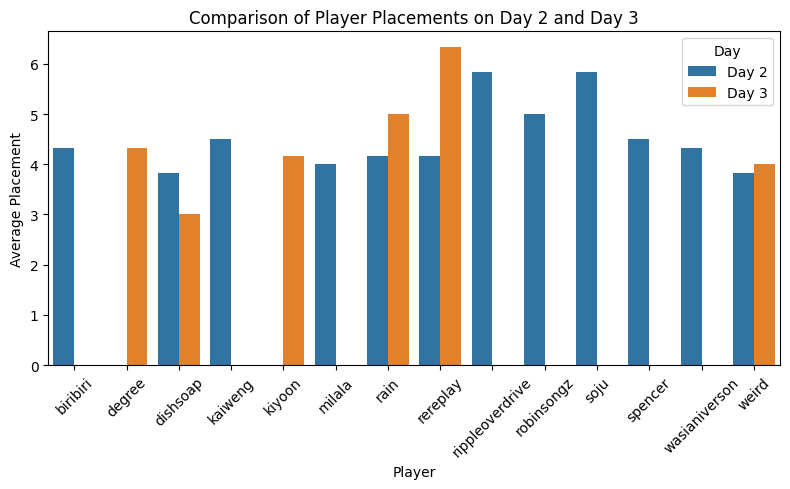

In [6]:
from sqlalchemy import text
with engine.connect() as conn:
    result = conn.execute(text('''
        SELECT players.player, 
               COALESCE(s1.placement_day2, '-') AS placement_day2, 
               COALESCE(s2.placement_day3, '-') AS placement_day3
          FROM (
               SELECT player FROM scores WHERE day = 2
                UNION
               SELECT player FROM scores WHERE day = 3
          ) AS players
          LEFT JOIN (
               SELECT player, ROUND(AVG(placement),2) AS placement_day2
                 FROM scores
                WHERE day = 2
                GROUP BY player
          ) s1 
            ON players.player = s1.player
          LEFT JOIN (
               SELECT player, ROUND(AVG(placement),2) AS placement_day3
               FROM scores
               WHERE day = 3
               GROUP BY player
          ) s2 
            ON players.player = s2.player
         ORDER BY players.player;
   '''))

    day_scores = result_to_dataframe(result)
print(day_scores)

day_scores.replace('-', pd.NA, inplace=True)

# Convert columns to numeric, coerce errors to NaN
day_scores['placement_day2'] = pd.to_numeric(day_scores['placement_day2'], errors='coerce')
day_scores['placement_day3'] = pd.to_numeric(day_scores['placement_day3'], errors='coerce')

# Melt the DataFrame to long format for easier plotting
melted_day_scores = pd.melt(day_scores, id_vars=['player'], var_name='Day', value_name='Placement')

# Adjust the 'Day' column to be readable
melted_day_scores['Day'] = melted_day_scores['Day'].map({
    'placement_day2': 'Day 2',
    'placement_day3': 'Day 3'
})

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x='player', y='Placement', hue='Day', data=melted_day_scores, errorbar=None)
plt.xticks(rotation=45)
plt.xlabel('Player')
plt.ylabel('Average Placement')
plt.title('Comparison of Player Placements on Day 2 and Day 3')
plt.legend(title='Day')

plt.tight_layout()
plt.show()

Nothing exceptional to note here. We query data from a derived table "players" and perform two left joins. The first join connects "players" with subquery "s1" that calculates average placement for each player on day 2. The second join connects the previous with subquery "s2" that calculates average placement for each player on day 3. Because this data was obtained through Twitch VODs (Videos On Demand), some players who did not record their VODs on either day 2 or day 3 did not have data for that day. Players who were elimated on day 2 obviously do not have day 3 data. In both these cases, NULL values were replaced with a hyphen using the COALESCE function. Lastly, placements were ROUNDed to 2 decimal points for readability. The result set is ordered by player names.

The data was further converted into a Pandas Dataframe and plotted in Seaborn.

## Player Statistics

In [7]:
with engine.connect() as conn:
    result = conn.execute(text('''
        SELECT player, ROUND(CAST(SUM("3cost") AS FLOAT)/COUNT(*),2) AS average_num_3costs, ROUND(AVG(pick_order),2) AS average_pick_order, ROUND(AVG(prekrug_slams),2) AS average_prekrug_slams, ROUND(AVG(placement),2) AS average_placement
          FROM scores 
         GROUP BY player
         ORDER BY average_placement ASC
   '''))
    user_stats = result_to_dataframe(result)
user_stats

,player,average_num_3costs,average_pick_order,average_prekrug_slams,average_placement
0,dishsoap,0.67,2.92,1.33,3.42
1,weird,0.92,1.92,1.50,3.92
2,milala,0.67,3.67,1.83,4.00
3,kiyoon,1.00,3.00,1.67,4.17
4,biribiri,0.67,2.33,1.50,4.33
5,degree,0.83,1.83,1.50,4.33
6,wasianiverson,0.67,2.67,1.50,4.33
7,kaiweng,1.00,2.83,2.17,4.50
8,spencer,0.50,2.00,1.50,4.50
9,rain,0.75,2.00,1.33,4.58


Some key insights:
- Here we see that weird has a much lower average pick order than other players with similar average placements. This suggests that weird is a strong "greedy" player (where "greedy" can be defined as contrasting to "flexible". A "greedy" player is more willing to save item components to create ideal item and is also more willing to "sack" (purposefully lose) HP to advantageously gain pick order on carousel for better units/components). Weird is well known as a strong non-flexible player, known for "hard-forcing" one or two team compositions with very specific item requirements, rather than playing flexibly.
- On the other hand, Milala, Kiyoon, and Dishsoap are known to be more flexible, as supported by their average pick order statistics.
- Surprisingly, despite being a known "flex" player, Dishsoap has a low average number of pre-krug slams. This in conjunction with Dishsoap's high average pick order suggests that Dishsoap is able to leverage tempo and save HP, while also valuing saving components in the early game.
- Looking at Kaiweng, we see that he has a high average pick order despite having high average number of pre-krug slams, suggesting that his item slams are not as impactful as he would like. There are a few possible cases here.
  - He is slamming low EV items whose downsides of being suboptimal outweigh the tempo gained for slamming
  - In the case above, he could be just getting very unlucky with item components (e.g. in same cases duplicate components) OR he could be overvaluing the tempo gained from slamming certain items
  - The items he is slamming are not flexible enough and force him to place specific team compositions, putting him at risk of unit shop randomness

# Modeling w/ Scikit-learn RandomForestRegressor

In [8]:
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [9]:
X = scores.drop(['points','day','player','placement'],axis=1)
y = scores['points']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
model = RandomForestRegressor(random_state=42)

n_estimators = [int(x) for x in np.linspace(1, 200, 10)]
criterion = ['squared_error', 'absolute_error', 'friedman_mse', 'poisson']
max_depth = [int(x) for x in np.linspace(10, 30, 1)]
max_depth.append(None)


params = {
    'n_estimators': n_estimators,
    'criterion': criterion,
    'max_depth': max_depth
}

grid_search = GridSearchCV(estimator=model, param_grid=params, cv=4, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)

Fitting 4 folds for each of 80 candidates, totalling 320 fits
Best parameters: {'criterion': 'absolute_error', 'max_depth': 10, 'n_estimators': 111}


In [12]:
model = RandomForestRegressor(random_state=42, criterion='absolute_error', max_depth=10, n_estimators=111)
sfs = SequentialFeatureSelector(model, n_features_to_select = 5, direction='backward')
sfs.fit(X_train, y_train)
print("Best features:", sfs.get_feature_names_out())

Best features: ['gold_not_units' '3cost' 'open_sword' 'open_chain' 'open_belt']


In [13]:
features = sfs.get_feature_names_out()

In [14]:
model = RandomForestRegressor(random_state=42, criterion='absolute_error', max_depth=10, n_estimators=111)
model.fit(X_train[features],y_train)
preds = model.predict(X_test[features])
preds = [round(x,0) for x in preds]

mse = mean_squared_error(y_test, preds)
r2 = r2_score(y_test, preds)
mae = mean_absolute_error(y_test, preds)

print(f'MSE: {mse}')
print(f'R^2: {r2}')
print(f'MAE: {mae}')
print(model.feature_importances_)
print(model.feature_names_in_)


MSE: 8.590909090909092
R^2: -0.5021676300578035
MAE: 2.5
[0.11659362 0.29591306 0.19191989 0.20326092 0.1923125 ]
['gold_not_units' '3cost' 'open_sword' 'open_chain' 'open_belt']


## First Pass Analysis

In [15]:
X.shape

(108, 13)

We see a very poor R^2 value at -0.50. TFT is a highly complex game driven by decision making and randomness throughout all stages of the game, where here we only look at features obtained from the first stage of the game. As a result, **we would expect that a regression model would have a low R^2 value** (where R^2 value represents the proportion of variance in the target variable that is predictable from the feature space). Despite this, a R^2 of -0.50 is very poor. A negative R^2 value indicates that our model performs worse than a model that predicts the average outcome of all cases (ignoring all independent variables). This would suggest that there is a **flaw in our model or feature selection.**

Possible explanation:
- One glaring issue is that the size of our dataset is not very big, we have ~108 observations, while the dimensionality of our feature space is 13. Our poor model can likely be attributed to **poor feature selection.** A challenge that arises from the curse of dimensionality is that **as feature dimensionality increases, the search space for finding optimal subset of features also grows rapidly**. This in combination with data sparsity from low observation size **makes it difficult to assess the relevance and gain of individual features accurately.** Let's try to address this by taking a qualitative look at the features in the feature space and manually reducing dimensionality before performing our SFS.

Qualitative look:
- High level competitive TFT players, while some may be more flexible than their counterparts, are generally very flexible players. They can play every team composition as needed and are experts at pivoting their end game team compositions based on their given items and available units. This in combination with the fact that each item component has a maximum "bag size" (total number of each component that can be dropped throughout the game) of 3 is designed such that item distribution is more or less balanced across the game. The implication of this is that **starting item component may not be as strong of a predictor as initially thought.** We see that the three features involving items (open_sword, open_chain, open_belt) have a sum of feature importances of about 0.6, meaning that they together are the strongest predictors of the outcome. As discussed, this is likely not the case. Let's remove features corresponding to the starting item components manually from the feature space.

In [16]:
features = ['gold_not_units', '3cost', 'prekrug_slams', 'neeko', 'pick_order']

In [17]:
model = RandomForestRegressor(random_state=42)

n_estimators = [int(x) for x in np.linspace(1, 200, 10)]
criterion = ['squared_error', 'absolute_error', 'friedman_mse', 'poisson']
max_depth = [int(x) for x in np.linspace(10, 30, 1)]
max_depth.append(None)


params = {
    'n_estimators': n_estimators,
    'criterion': criterion,
    'max_depth': max_depth
}

grid_search = GridSearchCV(estimator=model, param_grid=params, cv=4, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')
grid_search.fit(X_train[features], y_train)

print("Best parameters:", grid_search.best_params_)

Fitting 4 folds for each of 80 candidates, totalling 320 fits
Best parameters: {'criterion': 'absolute_error', 'max_depth': 10, 'n_estimators': 23}


In [18]:
model = RandomForestRegressor(random_state=42, criterion='absolute_error', max_depth=10, n_estimators=23)
model.fit(X_train[features],y_train)
preds = model.predict(X_test[features])
preds = [round(x,0) for x in preds]

mse = mean_squared_error(y_test, preds)
r2 = r2_score(y_test, preds)
mae = mean_absolute_error(y_test, preds)

print(f'MSE: {mse}')
print(f'R^2: {r2}')
print(f'MAE: {mae}')
print(model.feature_importances_)
print(model.feature_names_in_)


MSE: 4.7727272727272725
R^2: 0.16546242774566466
MAE: 1.7727272727272727
[0.11840337 0.22377084 0.2851394  0.07475787 0.29792853]
['gold_not_units' '3cost' 'prekrug_slams' 'neeko' 'pick_order']


## Discussion

After manually reducing feature space dimensionality, we see a much better R^2 value of 0.165. This is about in line with what we would expect from a highly complex game like TFT. 

# Conclusion

**Insights:**
- Prekrug_slams/pick_order: We see that these features have the highest importances. Given that TFT is a competitive, skill-based game and that prekrug_slams and pick_order are the two features that are player decision-driven rather than random, we would hope that these two features have the most impact on predicting player placement. This suggests that **early game player decisions have a bigger impact on placement than randomness.** This is a **very optimistic insight.**
- Neeko: We see that in our dataset that a positive outcome in the neeko predictor is only seen 4 times out of 108 observations. Given that this feature is the feature with the rarest positive frequency, we would hope that it does not strongly contribute to predicting player outcome (i.e. getting an extremely rare neeko significantly boosts your average placement in a game). Our observed feature importance corresponding to 'neeko' is 0.074. This is again **optimistic** and in line with what we would expect/hope.
- Gold_not_units/3cost: These two features are similar. When receiving units from drops, they can either be 2- or 3-cost drops. Otherwise, the drop can come in the form of gold of the same value. Seeing that 3cost has a feature importance twice than of gold_not_units, we can conclude that **receiving a 3-cost drop in the game may be significantly advantageous.** If the strength of receiving a 2-cost was about as strong as a 3-cost, we would likely see a more similar feature importance. We suggest **that there may be a potential imblanace in game mechanics involving unit/gold drops.** While feature importances provide insights into predictive power of features in our model, they do not directly measure fairness or balance in game. **We would have to look at player performance data for wide ranges of scenarios and/or control for other variables to draw definite conclusions about game balance.**
  